In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
political_events = pd.read_csv('data/political_events.csv')
sp500 = pd.read_csv('data/sp500.csv')
sp500 = sp500.drop(columns='Unnamed: 0')

In [3]:
# Helpers
def add_event_windows(events: pd.DataFrame, pre_days=30, post_days=10):
    """
    Build calendar windows around each event date (calendar days).
    We'll later map these to trading days by merging onto the SP500 calendar.
    """
    ev = events.copy()
    ev["date"] = pd.to_datetime(ev["date"])
    ev["win_start"] = ev["date"] - pd.Timedelta(days=pre_days)
    ev["win_end"]   = ev["date"] + pd.Timedelta(days=post_days)
    return ev

def mark_event_days(sp: pd.DataFrame, ev_windows: pd.DataFrame):
    """
    Mark whether each SP500 trading day falls within ANY event window.
    """
    sp = sp.copy()
    sp["is_event_window"] = False
    for _, row in ev_windows.iterrows():
        mask = (sp["Date"] >= row["win_start"]) & (sp["Date"] <= row["win_end"])
        sp.loc[mask, "is_event_window"] = True
    return sp

def realized_vol(returns: pd.Series, window: int):
    """Annualization optional; here use simple rolling std of daily returns."""
    return returns.rolling(window).std()


In [4]:
sp500 = sp500.copy()
political_events = political_events.copy()

sp500["Date"] = pd.to_datetime(sp500["Date"])
sp500 = sp500.sort_values("Date").reset_index(drop=True)

political_events["date"] = pd.to_datetime(political_events["date"])
political_events = political_events.sort_values("date").reset_index(drop=True)

In [5]:
# Log returns
sp500["log_close"] = np.log(sp500["Close"])
sp500["r"] = sp500["log_close"].diff()

# Squared returns 
sp500["r2"] = sp500["r"]**2

# Rolling realized volatility 
sp500["rv_5"]  = realized_vol(sp500["r"], 5)
sp500["rv_10"] = realized_vol(sp500["r"], 10)
sp500["rv_20"] = realized_vol(sp500["r"], 20)

sp500 = sp500.dropna(subset=["r"]).reset_index(drop=True)

In [6]:
# Define "event windows" and "non-event" days for fitting null model
ev_windows = add_event_windows(political_events, pre_days=3, post_days=3)
sp500 = mark_event_days(sp500, ev_windows)

non_event = sp500.loc[~sp500["is_event_window"]].copy()

print("Trading days:", len(sp500))
print("Non-event trading days used to fit null:", len(non_event))

Trading days: 8816
Non-event trading days used to fit null: 8678


In [7]:
# Build the data-driven stochastic process:
#       r_t = mu + sigma_t * eps_t, eps_t from empirical standardized residuals

# Choose volatility estimator for sigma_t
sigma_window = 20
sp500["sigma_t"] = sp500["r"].rolling(sigma_window).std()

sp500["sigma_t"] = sp500["sigma_t"].fillna(sp500["r"].expanding(min_periods=5).std())
sp500["sigma_t"] = sp500["sigma_t"].fillna(sp500["r"].std()) 

mu_hat = non_event["r"].mean()

# eps = (r - mu)/sigma
non_event = non_event.merge(sp500[["Date","sigma_t"]], on="Date", how="left", suffixes=("","_sp"))
non_event["eps"] = (non_event["r"] - mu_hat) / non_event["sigma_t"]

eps_pool = non_event["eps"].replace([np.inf, -np.inf], np.nan).dropna().values

print("mu_hat:", mu_hat)
print("eps_pool size:", eps_pool.size)

mu_hat: 0.00028810092336885334
eps_pool size: 8678


In [8]:

# Simulate return paths under the null (no election effects)
def simulate_null_paths(n_paths: int, dates: pd.Series, sigma_t: np.ndarray, mu: float, eps_pool: np.ndarray, seed=0):
    """
    Simulate r_t for each date using the observed sigma_t sequence (time-varying volatility)
    and iid eps sampled with replacement from empirical standardized residuals.
    """
    rng = np.random.default_rng(seed)
    T = len(dates)
    # sample eps for each (path, time)
    eps = rng.choice(eps_pool, size=(n_paths, T), replace=True)
    r_sim = mu + eps * sigma_t[None, :]
    return r_sim

N_PATHS = 5000
r_sim = simulate_null_paths(
    n_paths=N_PATHS,
    dates=sp500["Date"],
    sigma_t=sp500["sigma_t"].values,
    mu=mu_hat,
    eps_pool=eps_pool,
    seed=42
)

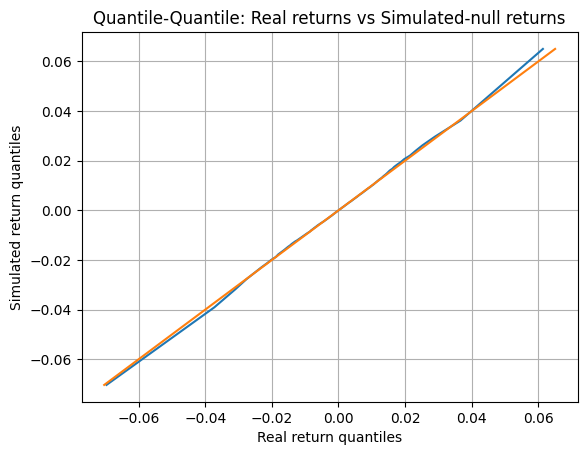

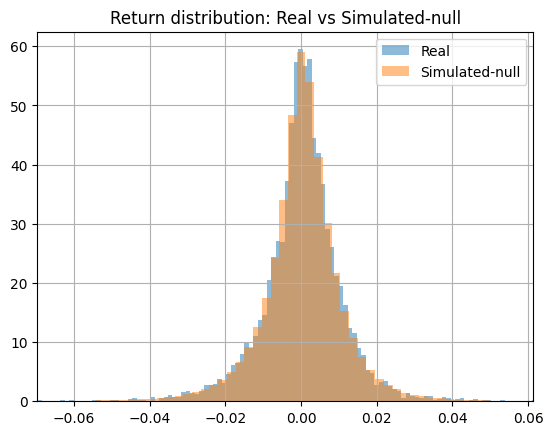

In [12]:
# QQ
real_r = sp500["r"].values
sim_r_flat = r_sim.reshape(-1)

qs = np.linspace(0.001, 0.999, 200)
real_q = np.quantile(real_r, qs)
sim_q  = np.quantile(sim_r_flat, qs)

plt.figure()
plt.plot(real_q, sim_q)
mn = min(real_q.min(), sim_q.min())
mx = max(real_q.max(), sim_q.max())
plt.plot([mn, mx], [mn, mx])
plt.title("Quantile-Quantile: Real returns vs Simulated-null returns")
plt.xlabel("Real return quantiles")
plt.ylabel("Simulated return quantiles")
plt.grid(True)
plt.show()


plt.figure()
plt.hist(real_r, bins=200, density=True, alpha=0.5, label="Real")
plt.hist(sim_r_flat, bins=200, density=True, alpha=0.5, label="Simulated-null")
plt.title("Return distribution: Real vs Simulated-null")
plt.xlim(np.quantile(real_r, 0.001), np.quantile(real_r, 0.999))
plt.legend()
plt.grid(True)


,event_date,event_type,obs_stat,p_right,p_two,null_mean,null_sd
0,2016-11-08,presidential_election,0.010596,0.0084,0.0168,0.005433,0.001769
1,2021-01-06,certification_event,0.009895,0.0156,0.0312,0.005636,0.001727
2,2009-01-20,inauguration,0.033931,0.0174,0.0348,0.019033,0.006252
3,2024-11-05,presidential_election,0.011507,0.0232,0.0464,0.006811,0.002087
4,2005-01-20,inauguration,0.008667,0.0494,0.0988,0.005439,0.001774
5,2012-11-06,presidential_election,0.010975,0.0676,0.1352,0.007359,0.002284
6,2006-11-07,midterm_election,0.006214,0.0860,0.1720,0.004271,0.001345
7,2022-11-08,midterm_election,0.020083,0.1726,0.3452,0.015616,0.004767
8,2020-11-03,presidential_election,0.015672,0.2230,0.4460,0.012822,0.003983
9,2021-01-20,inauguration,0.007891,0.2328,0.4656,0.006456,0.002092


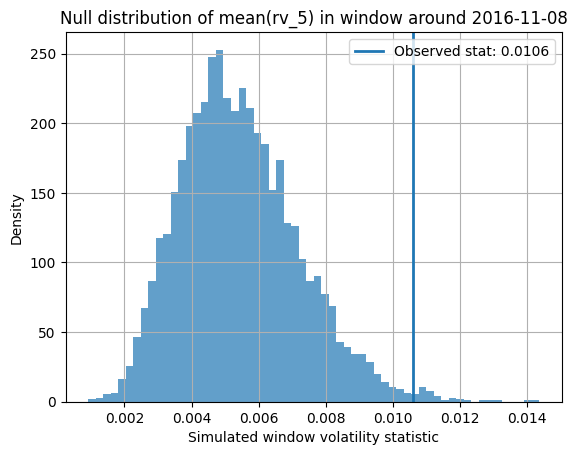

In [10]:
VOL_COL = "rv_5"   
WINDOW_STAT = "mean"

# Get actual (observed) event-window volatility stats
event_stats = []
for _, row in ev_windows.iterrows():
    w = sp500[(sp500["Date"] >= row["win_start"]) & (sp500["Date"] <= row["win_end"])]
    val = w[VOL_COL].mean() if WINDOW_STAT == "mean" else w[VOL_COL].max()
    event_stats.append({
        "event_date": row["date"],
        "event_type": row["event_type"],
        "description": row["description"],
        "stat": val
    })
event_stats = pd.DataFrame(event_stats).dropna(subset=["stat"]).reset_index(drop=True)

# Now compute the same statistic on simulated data, aligned to the same windows.
date_to_idx = pd.Series(sp500.index.values, index=sp500["Date"]).to_dict()

# Precompute rolling vols for each simulated path to match VOL_COL choice
def rolling_std_matrix(r_mat, window):
    # r_mat shape (N, T)
    N, T = r_mat.shape
    out = np.full((N, T), np.nan)
    for t in range(window-1, T):
        seg = r_mat[:, t-window+1:t+1]
        out[:, t] = np.std(seg, axis=1, ddof=1)
    return out

vol_window = int(VOL_COL.split("_")[1])
rv_sim = rolling_std_matrix(r_sim, vol_window)

# For each event window, compute statistic for every path.
null_by_event = []
for _, row in ev_windows.iterrows():
    wmask = (sp500["Date"] >= row["win_start"]) & (sp500["Date"] <= row["win_end"])
    idxs = sp500.index[wmask].values
    if len(idxs) == 0:
        continue
    # pull simulated realized vol in that window: shape (N_PATHS, len(idxs))
    block = rv_sim[:, idxs]
    if WINDOW_STAT == "mean":
        sim_stat = np.nanmean(block, axis=1)
    else:
        sim_stat = np.nanmax(block, axis=1)

    null_by_event.append(pd.DataFrame({
        "event_date": row["date"],
        "event_type": row["event_type"],
        "description": row["description"],
        "sim_stat": sim_stat
    }))

null_by_event = pd.concat(null_by_event, ignore_index=True)

# Compute Monte Carlo p-values (two-sided or right-tail)
pvals = []
for _, ev in event_stats.iterrows():
    sims = null_by_event.loc[null_by_event["event_date"] == ev["event_date"], "sim_stat"].dropna().values
    if sims.size == 0:
        continue
    obs = ev["stat"]
    p_right = np.mean(sims >= obs)
    p_two   = 2 * min(np.mean(sims >= obs), np.mean(sims <= obs))
    pvals.append((ev["event_date"], ev["event_type"], obs, p_right, min(p_two, 1.0), sims.mean(), sims.std()))

pvals = pd.DataFrame(pvals, columns=["event_date","event_type","obs_stat","p_right","p_two","null_mean","null_sd"])
pvals = pvals.sort_values(["p_right"]).reset_index(drop=True)

display(pvals.head(15))

# Example plot: distribution for ONE event (pick the most "significant" by p_right)
if len(pvals) > 0:
    chosen = pvals.iloc[0]["event_date"]
    sims = null_by_event.loc[null_by_event["event_date"] == chosen, "sim_stat"].dropna().values
    obs = pvals.iloc[0]["obs_stat"]
    plt.figure()
    plt.hist(sims, bins=60, density=True, alpha=0.7)
    plt.axvline(obs, linewidth=2, label=f"Observed stat: {obs:.4g}")
    plt.title(f"Null distribution of {WINDOW_STAT}({VOL_COL}) in window around {chosen.date()}")
    plt.xlabel("Simulated window volatility statistic")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
